## Código Objetivo

In [1]:
import ee
from osgeo import gdal
from osgeo import osr
import pandas as pd
import numpy as np
import time
import logging
import requests
import zipfile
import os

from save_gee_image_tiff import save_gee_tiff
ee.Initialize()

In [2]:
#Recorte um pouco maior que as áreas das barragens, cabem ajustes
#Fundão: "-43.49513553785783,-20.24537533206166,-43.42406772779923,-20.191089981448055"
#B1: "-44.13576882693976,-20.14040952973489,-44.107444699742494,-20.11204199216084"
#Vargem Grande: "-43.89263731841176,-20.195337749895153,-43.84543043974965,-20.144097041358684"
#B3B4: "-43.95636224236322,-20.04993942822698,-43.95282172646356,-20.046230457446246"
#Pontal: "-43.18927205525049,-19.629407030327528,-43.1740371080459,-19.619382228799804"
#Itabiruçu: "-43.2997830481906,-19.69176876639166,-43.27884036020232,-19.67512078959624"

coordenadas = "-43.49513553785783,-20.24537533206166,-43.42406772779923,-20.191089981448055"
x1,y1,x2,y2 = coordenadas.split(",")
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])
datas = "2013-01-01,2020-12-29"
inicio,fim = datas.split(",")
colecao = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filterBounds(geometria).filterDate(inicio,fim).filterMetadata('CLOUD_COVER','less_than', 10)
#colecao = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(geometria).filterDate(inicio,fim).filterMetadata('CLOUD_COVER','less_than', 10)
print("Total de imagens encontradas: "+str(colecao.size().getInfo()))

Total de imagens encontradas: 71


In [3]:
blue = 'B2'
green = 'B3'
red = 'B4'
nir = 'B5'
pan = 'B8'

def ndvi(imagem):
    ndvi = imagem.expression('(nir - red) / (nir + red)',{'nir':imagem.select(nir),'red':imagem.select(red)}).rename('ndvi')
    return imagem.addBands(ndvi)

def ndwi(imagem):
    ndwi = imagem.expression('(nir - green) / (nir + green)',{'nir':imagem.select(nir),'green':imagem.select(green)}).rename('ndwi')
    return imagem.addBands(ndwi)

cole_ori = colecao
colecao = colecao.map(ndvi)
colecao = colecao.map(ndwi)
imagem = colecao.median()
print(imagem.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA', 'ndvi', 'ndwi']


In [4]:
listaColecao = colecao.toList(colecao.size())
df = pd.DataFrame(columns=['Data','ID','Sequencia'])
for j in range(colecao.size().getInfo()):
    information = ee.Image(listaColecao.get(j)).getInfo()
    name = information['id']
    df.loc[j] = [name[42:] + '-' + name[40:42] + '-' + name[36:40]] + [information['id']] + ['t' + str(j+1)]
    
df.set_index('Sequencia', inplace=True)    
df.head()

Data                                            ID
Sequencia                                                          
t1         02-08-2013  LANDSAT/LC08/C01/T1_TOA/LC08_217074_20130802
t2         05-08-2014  LANDSAT/LC08/C01/T1_TOA/LC08_217074_20140805
t3         25-09-2015  LANDSAT/LC08/C01/T1_TOA/LC08_217074_20150925
t4         11-10-2015  LANDSAT/LC08/C01/T1_TOA/LC08_217074_20151011
t5         25-07-2016  LANDSAT/LC08/C01/T1_TOA/LC08_217074_20160725

In [5]:
def ext_lat_lon_pixel30(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=30,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

def ext_lat_lon_pixel15(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=15,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

In [595]:
bands = ['ndvi','ndwi']
icopy = ee.Image.pixelLonLat().addBands( imagem.select(bands) )
icopy = icopy.reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,maxPixels=1e8,scale=15)
arrayList=[]
for i in range(1):
    data = np.array((ee.Array(icopy.get(bands[i])).getInfo()),np.float32)
    arrayList.append(data)
    
arrayList

[array([1.6340773e-05, 1.6340773e-05, 7.7378028e-04, ..., 1.7300226e-03,
        1.8102889e-03, 1.8102889e-03], dtype=float32)]

In [611]:
bandas = ['bluep','greenp','redp','nirp','ndvip','ndwip']
path_out = 'Mariall_pan.tif'
save_gee_tiff(imagem,geometria,bandas,-99999,15,path_out)

'ok...'

In [6]:
lista_sm = ee.List([])
for im in range(colecao.size().getInfo()):
    sub_med = ee.Image(listaColecao.get(im)).subtract(imagem)
    lista_sm = lista_sm.add(sub_med)
    
col_ajust = ee.ImageCollection(lista_sm)

In [448]:
blue = 'B2'
green = 'B3'
red = 'B4'
nir = 'B5'
pan = 'B8'
def nirp(imagem):
    nirp = imagem.expression('(nir * pan * 4) / (nir + red + green + blue + 4)',{'nir':imagem.select(nir),
                                                                          'pan':imagem.select(pan),
                                                                          'blue':imagem.select(blue),
                                                                          'red':imagem.select(red),
                                                                          'green':imagem.select(green)}).rename('nirp')
    return imagem.addBands(nirp)
def redp(imagem):
    redp = imagem.expression('(red * pan * 4) / (nir + red + green + blue + 4)',{'nir':imagem.select(nir),
                                                                          'pan':imagem.select(pan),
                                                                          'red':imagem.select(red),
                                                                          'blue':imagem.select(blue),
                                                                          'green':imagem.select(green)}).rename('redp')
    return imagem.addBands(redp)
def greenp(imagem):
    greenp = imagem.expression('(green * pan * 4) / (nir + red + green + blue + 4)',{'nir':imagem.select(nir),
                                                                          'pan':imagem.select(pan),
                                                                          'blue':imagem.select(blue),
                                                                          'red':imagem.select(red),
                                                                          'green':imagem.select(green)}).rename('greenp')
    return imagem.addBands(greenp)
def bluep(imagem):
    bluep = imagem.expression('(blue * pan * 4) / (nir + red + green + blue + 4)',{'nir':imagem.select(nir),
                                                                          'blue':imagem.select(blue),
                                                                          'pan':imagem.select(pan),
                                                                          'red':imagem.select(red),
                                                                          'green':imagem.select(green)}).rename('bluep')
    return imagem.addBands(bluep)
def ndvip(imagem):
    ndvip = imagem.expression('(ndvi * pan * 5) / (ndvi + nir + red + green + blue + 5)',{'ndvi':imagem.select('ndvi'),
                                                           'nir':imagem.select(nir),
                                                           'blue':imagem.select(blue),
                                                           'pan':imagem.select(pan),
                                                           'red':imagem.select(red),
                                                           'green':imagem.select(green)}).rename('ndvip')
    return imagem.addBands(ndvip)
def ndwip(imagem):
    ndwip = imagem.expression('(ndwi * pan * 5) / (ndwi + nir + red + green + blue + 5)',{'ndwi':imagem.select('ndwi'),
                                                           'nir':imagem.select(nir),
                                                           'blue':imagem.select(blue),
                                                           'pan':imagem.select(pan),
                                                           'red':imagem.select(red),
                                                           'green':imagem.select(green)}).rename('ndwip')
    return imagem.addBands(ndwip)


cole = col_ajust.map(nirp)
cole = cole.map(redp)
cole = cole.map(greenp)
cole = cole.map(bluep)
cole = cole.map(ndvip)
cole = cole.map(ndwip)
imagem = cole.median()
print(imagem.bandNames().getInfo())
img_15 = imagem.clipToBoundsAndScale(geometry=geometria,scale=15)
print(img_15.select(['redp','greenp','bluep']).getThumbUrl({'min':0, 'max':0.05}))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA', 'ndvi', 'ndwi', 'nirp', 'redp', 'greenp', 'bluep', 'ndvip', 'ndwip']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b12e4ed456cc246a7e8f30ad7903191-031ca199d312c12b88c23088197b4a4c:getPixels


In [8]:
listaCN = cole.toList(cole.size())
defaultDummy = -99999
df_r15 = pd.DataFrame()
di = {}
dias = df['Data'].values
for j in range(cole.size().getInfo()):
    templat = 'Lat_' + str(j+1)
    templon = 'Lon_' + str(j+1)
    tempndvi = str(dias[j])
    img = ee.Image(defaultDummy).blend(ee.Image(listaCN.get(j)))
    lat15, lon15, ind15 = ext_lat_lon_pixel15(img,geometria,['ndvip'])
    di[tempndvi] = ind15[0]
    
df_r15 = df_r15.from_dict(di)
df_r15 = df_r15.assign(Latitude = lat15)
df_r15 = df_r15.assign(Longitude = lon15)
cols = df_r15.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_r15 = df_r15[cols]
df_r15.head()

Latitude  Longitude  02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
0 -20.245309 -43.495011   -0.000033   -0.000194   -0.000479   -0.000229   
1 -20.245309 -43.494876   -0.000052   -0.000198   -0.000610   -0.000322   
2 -20.245309 -43.494742   -0.000163   -0.000006   -0.000684   -0.000363   
3 -20.245309 -43.494607   -0.000122   -0.000007   -0.000631   -0.000326   
4 -20.245309 -43.494472   -0.000192   -0.000004   -0.000604   -0.000321   

   25-07-2016  10-08-2016  29-08-2017  20-01-2018  ...  10-08-2019  \
0   -0.000003   -0.000524   -0.000116    0.000105  ...   -0.008105   
1   -0.000058   -0.000484   -0.000079    0.000269  ...   -0.008722   
2   -0.000156   -0.000404   -0.000046    0.000361  ...   -0.007011   
3   -0.000064   -0.000422   -0.000084    0.000048  ...   -0.004996   
4   -0.000171   -0.000414   -0.000083    0.000124  ...   -0.005141   

   11-09-2019  13-10-2019  16-12-2019  02-02-2020  09-06-2020  25-06-2020  \
0   -0.000194    0.000002   -0.000915   -0.000670   -0.000495   -0.000296   
1   -0.000225   -0.000045   -0.000635   -0.000615   -0.000664   -0.000358   
2   -0.000065    0.000003   -0.000711   -0.000692   -0.000970   -0.000502   
3   -0.000062    0.000004   -0.001143   -0.001000   -0.000783   -0.000540   
4   -0.000057    0.000005   -0.000846   -0.000968   -0.001078   -0.000602   

   11-07-2020  13-09-2020  29-09-2020  
0   -0.037669   -0.000018   -0.000845  
1   -0.052209    0.000019   -0.000995  
2   -0.058080    0.000003   -0.000741  
3   -0.065237   -0.000002   -0.000600  
4   -0.071281    0.000010   -0.000700  

[5 rows x 73 columns]

In [9]:
copia = df_r15
copia[['Latitude','Longitude']] = copia[['Latitude','Longitude']].round(4)
copia.head()

Latitude  Longitude  02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
0  -20.2453   -43.4950   -0.000033   -0.000194   -0.000479   -0.000229   
1  -20.2453   -43.4949   -0.000052   -0.000198   -0.000610   -0.000322   
2  -20.2453   -43.4947   -0.000163   -0.000006   -0.000684   -0.000363   
3  -20.2453   -43.4946   -0.000122   -0.000007   -0.000631   -0.000326   
4  -20.2453   -43.4945   -0.000192   -0.000004   -0.000604   -0.000321   

   25-07-2016  10-08-2016  29-08-2017  20-01-2018  ...  10-08-2019  \
0   -0.000003   -0.000524   -0.000116    0.000105  ...   -0.008105   
1   -0.000058   -0.000484   -0.000079    0.000269  ...   -0.008722   
2   -0.000156   -0.000404   -0.000046    0.000361  ...   -0.007011   
3   -0.000064   -0.000422   -0.000084    0.000048  ...   -0.004996   
4   -0.000171   -0.000414   -0.000083    0.000124  ...   -0.005141   

   11-09-2019  13-10-2019  16-12-2019  02-02-2020  09-06-2020  25-06-2020  \
0   -0.000194    0.000002   -0.000915   -0.000670   -0.000495   -0.000296   
1   -0.000225   -0.000045   -0.000635   -0.000615   -0.000664   -0.000358   
2   -0.000065    0.000003   -0.000711   -0.000692   -0.000970   -0.000502   
3   -0.000062    0.000004   -0.001143   -0.001000   -0.000783   -0.000540   
4   -0.000057    0.000005   -0.000846   -0.000968   -0.001078   -0.000602   

   11-07-2020  13-09-2020  29-09-2020  
0   -0.037669   -0.000018   -0.000845  
1   -0.052209    0.000019   -0.000995  
2   -0.058080    0.000003   -0.000741  
3   -0.065237   -0.000002   -0.000600  
4   -0.071281    0.000010   -0.000700  

[5 rows x 73 columns]

In [151]:
df_r15c = df_r15.set_index(['Latitude','Longitude'])
df_r15c.head()

02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000033   -0.000194   -0.000479   -0.000229   
         -43.4949    -0.000052   -0.000198   -0.000610   -0.000322   
         -43.4947    -0.000163   -0.000006   -0.000684   -0.000363   
         -43.4946    -0.000122   -0.000007   -0.000631   -0.000326   
         -43.4945    -0.000192   -0.000004   -0.000604   -0.000321   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000003   -0.000524   -0.000116    0.000105   
         -43.4949    -0.000058   -0.000484   -0.000079    0.000269   
         -43.4947    -0.000156   -0.000404   -0.000046    0.000361   
         -43.4946    -0.000064   -0.000422   -0.000084    0.000048   
         -43.4945    -0.000171   -0.000414   -0.000083    0.000124   

                    28-05-2018    01-09-2018  ...  10-08-2019  11-09-2019  \
Latitude Longitude                            ...                           
-20.2453 -43.4950     0.000027 -8.441663e-06  ...   -0.008105   -0.000194   
         -43.4949    -0.000087 -2.466818e-06  ...   -0.008722   -0.000225   
         -43.4947     0.000229  1.255498e-07  ...   -0.007011   -0.000065   
         -43.4946     0.000228 -5.340677e-07  ...   -0.004996   -0.000062   
         -43.4945     0.000277  5.417275e-07  ...   -0.005141   -0.000057   

                    13-10-2019  16-12-2019  02-02-2020  09-06-2020  \
Latitude Longitude                                                   
-20.2453 -43.4950     0.000002   -0.000915   -0.000670   -0.000495   
         -43.4949    -0.000045   -0.000635   -0.000615   -0.000664   
         -43.4947     0.000003   -0.000711   -0.000692   -0.000970   
         -43.4946     0.000004   -0.001143   -0.001000   -0.000783   
         -43.4945     0.000005   -0.000846   -0.000968   -0.001078   

                    25-06-2020  11-07-2020  13-09-2020  29-09-2020  
Latitude Longitude                                                  
-20.2453 -43.4950    -0.000296   -0.037669   -0.000018   -0.000845  
         -43.4949    -0.000358   -0.052209    0.000019   -0.000995  
         -43.4947    -0.000502   -0.058080    0.000003   -0.000741  
         -43.4946    -0.000540   -0.065237   -0.000002   -0.000600  
         -43.4945    -0.000602   -0.071281    0.000010   -0.000700  

[5 rows x 71 columns]

In [184]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def count_anomaly(predict):
    return np.count_nonzero(predict==-1)

def OCSVM(df):
    y = df.to_numpy().reshape(-1, 1)
    res = OneClassSVM(nu=0.05).fit_predict(y)
    return count_anomaly(res)

def RC(df):
    y = df.to_numpy().reshape(-1, 1)
    res = EllipticEnvelope(support_fraction=5,random_state=0).fit_predict(y)
    return count_anomaly(res)

def ISO(df):
    y = df.to_numpy().reshape(-1, 1)
    res = IsolationForest(n_estimators=5,random_state=0).fit_predict(y)
    return count_anomaly(res)

def LOCAL(df):
    y = df.to_numpy().reshape(-1, 1)
    res = LocalOutlierFactor(n_neighbors=5, metric='braycurtis').fit_predict(y)
    return count_anomaly(res)

In [185]:
dt = df_r15c.tail()
inicio = time.time()
dt.loc[:,'One-Class SVM'] = dt.apply(OCSVM, axis=1)
inicio2 = time.time()
dt.loc[:,'Robust Covariance'] = dt.apply(RC, axis=1)
inicio3 = time.time()
dt.loc[:,'Isolation Forest'] = dt.apply(ISO, axis=1)
inicio4 = time.time()
dt.loc[:,'Local Outlier Factor'] = dt.apply(LOCAL, axis=1)
fim = time.time()
print((inicio2 - inicio)*50000/60, "minutos") 
print((inicio3 - inicio2)*50000/60, "minutos")
print((inicio4 - inicio3)*50000/60, "minutos")
print((fim - inicio4)*50000/60, "minutos")
dt.head()

11.672178904215494 minutos
46.678781509399414 minutos
129.48870658874512 minutos
12.919902801513672 minutos


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                     
-20.1911 -43.4247   5.426648e-07   -0.000277   -0.000893   -0.000736   
         -43.4245   1.816329e-07   -0.000183   -0.000841   -0.000711   
         -43.4244   1.599184e-07   -0.000257   -0.000944   -0.000753   
         -43.4243  -3.901135e-06   -0.000213   -0.001095   -0.000850   
         -43.4241  -5.998139e-06   -0.000194   -0.000978   -0.000785   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.1911 -43.4247    -0.000012   -0.000529   -0.000012    0.000327   
         -43.4245    -0.000052   -0.000406    0.000001    0.000080   
         -43.4244    -0.000060   -0.000524   -0.000022    0.000210   
         -43.4243    -0.000032   -0.000513   -0.000012    0.000099   
         -43.4241    -0.000050   -0.000437    0.000013    0.000070   

                      28-05-2018  01-09-2018  ...  02-02-2020  09-06-2020  \
Latitude Longitude                            ...                           
-20.1911 -43.4247   2.312226e-06    0.000004  ...   -0.000012   -0.000087   
         -43.4245   2.434125e-05   -0.000012  ...   -0.000234   -0.000171   
         -43.4244   9.709284e-06   -0.000012  ...   -0.000195   -0.000191   
         -43.4243   7.262874e-07   -0.000014  ...   -0.000156   -0.000155   
         -43.4241  -5.876870e-07   -0.000002  ...   -0.000127   -0.000145   

                    25-06-2020    11-07-2020    13-09-2020  29-09-2020  \
Latitude Longitude                                                       
-20.1911 -43.4247    -0.000036  1.257525e-05 -4.003058e-06   -0.000907   
         -43.4245    -0.000097  3.041122e-07  9.981144e-07   -0.000884   
         -43.4244    -0.000100 -7.915465e-06  9.286759e-06   -0.000946   
         -43.4243    -0.000095 -1.063504e-06  4.192819e-06   -0.000879   
         -43.4241    -0.000053 -2.401823e-07 -4.506313e-06   -0.000940   

                    One-Class SVM  Robust Covariance  Isolation Forest  \
Latitude Longitude                                                       
-20.1911 -43.4247               4                  8                 9   
         -43.4245               5                  8                 9   
         -43.4244               4                  8                 8   
         -43.4243               5                  8                 8   
         -43.4241               3                  8                 8   

                    Local Outlier Factor  
Latitude Longitude                        
-20.1911 -43.4247                     12  
         -43.4245                      9  
         -43.4244                      9  
         -43.4243                      8  
         -43.4241                      8  

[5 rows x 75 columns]

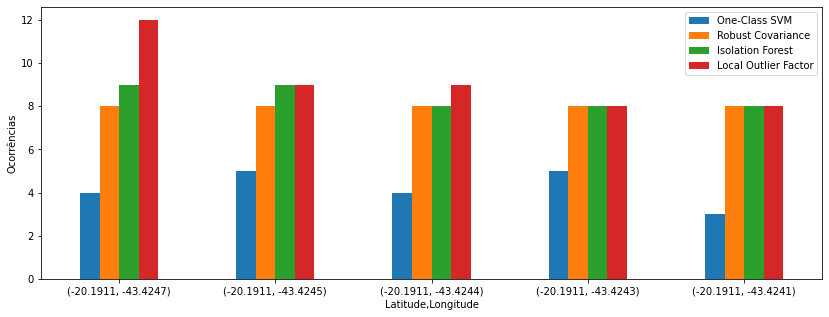

In [186]:
import matplotlib.pyplot as plt
ax = dt.loc[:,'One-Class SVM':'Local Outlier Factor'].plot(figsize=(14,5), kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Ocorrências')
plt.show()

In [188]:
st = time.time()
dt2 = df_r15c
dt2['One-Class SVM'] = dt2.loc[:,'02-08-2013':'29-09-2020'].apply(OCSVM, axis=1)
dt2['Local Outlier Factor'] = dt2.loc[:,'02-08-2013':'29-09-2020'].apply(LOCAL, axis=1)
dt2['Isolation Forest'] = dt2.loc[:,'02-08-2013':'29-09-2020'].apply(ISO, axis=1)
dt2['Robust Covariance'] = dt2.loc[:,'02-08-2013':'29-09-2020'].apply(RC, axis=1)
fin = time.time()
print((fin - st)/60)
dt2.head()

124.35308041175206


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000033   -0.000194   -0.000479   -0.000229   
         -43.4949    -0.000052   -0.000198   -0.000610   -0.000322   
         -43.4947    -0.000163   -0.000006   -0.000684   -0.000363   
         -43.4946    -0.000122   -0.000007   -0.000631   -0.000326   
         -43.4945    -0.000192   -0.000004   -0.000604   -0.000321   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000003   -0.000524   -0.000116    0.000105   
         -43.4949    -0.000058   -0.000484   -0.000079    0.000269   
         -43.4947    -0.000156   -0.000404   -0.000046    0.000361   
         -43.4946    -0.000064   -0.000422   -0.000084    0.000048   
         -43.4945    -0.000171   -0.000414   -0.000083    0.000124   

                    28-05-2018    01-09-2018  ...  02-02-2020  09-06-2020  \
Latitude Longitude                            ...                           
-20.2453 -43.4950     0.000027 -8.441663e-06  ...   -0.000670   -0.000495   
         -43.4949    -0.000087 -2.466818e-06  ...   -0.000615   -0.000664   
         -43.4947     0.000229  1.255498e-07  ...   -0.000692   -0.000970   
         -43.4946     0.000228 -5.340677e-07  ...   -0.001000   -0.000783   
         -43.4945     0.000277  5.417275e-07  ...   -0.000968   -0.001078   

                    25-06-2020  11-07-2020  13-09-2020  29-09-2020  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000296   -0.037669   -0.000018   -0.000845   
         -43.4949    -0.000358   -0.052209    0.000019   -0.000995   
         -43.4947    -0.000502   -0.058080    0.000003   -0.000741   
         -43.4946    -0.000540   -0.065237   -0.000002   -0.000600   
         -43.4945    -0.000602   -0.071281    0.000010   -0.000700   

                    One-Class SVM  Local Outlier Factor  Isolation Forest  \
Latitude Longitude                                                          
-20.2453 -43.4950               2                     8                 9   
         -43.4949               3                    11                10   
         -43.4947               3                     8                10   
         -43.4946               1                    14                 9   
         -43.4945               4                     8                 9   

                    Robust Covariance  
Latitude Longitude                     
-20.2453 -43.4950                   7  
         -43.4949                   8  
         -43.4947                   8  
         -43.4946                   7  
         -43.4945                   7  

[5 rows x 75 columns]

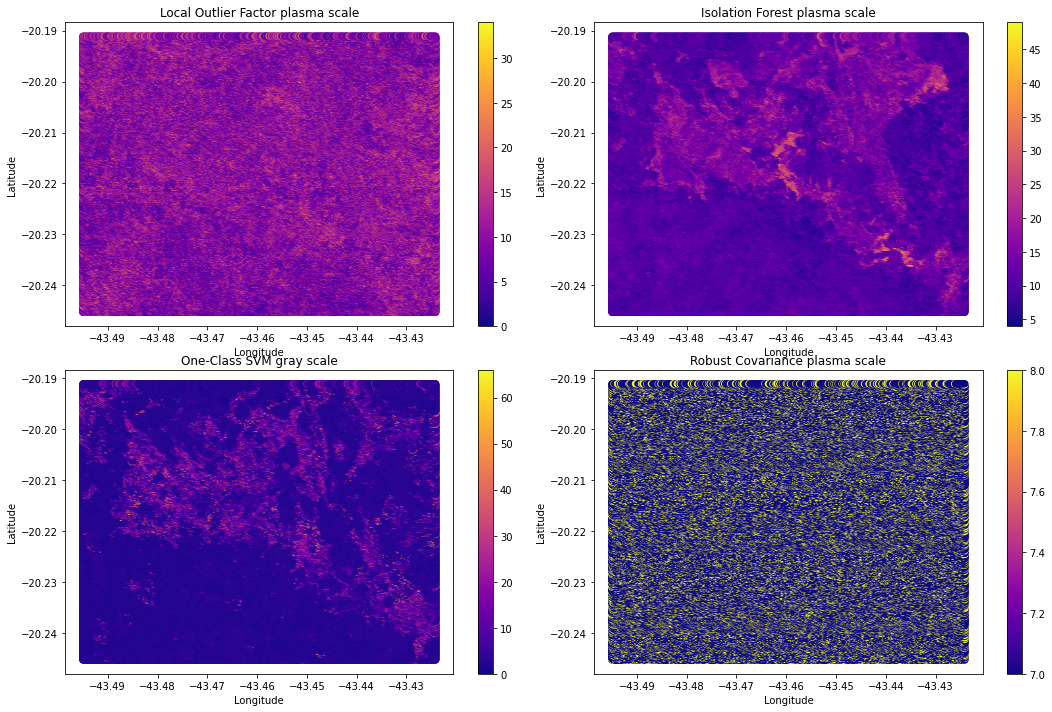

In [189]:
y = df_r15['Latitude'].values
x = df_r15['Longitude'].values
fig, ax = plt.subplots(2,2, figsize=(15,10))
mask1 = dt2['Local Outlier Factor'].values
mask2 = dt2['Isolation Forest'].values
mask3 = dt2['One-Class SVM'].values
mask4 = dt2['Robust Covariance'].values
ax[0,0].scatter(x,y,c=mask1,cmap='plasma')
ax[0,0].set_title('Local Outlier Factor plasma scale')
plt.colorbar(ax[0,0].scatter(x,y,c=mask1,cmap='plasma'),ax=ax[0,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[0,1].scatter(x,y,c=mask2,cmap='plasma')
ax[0,1].set_title('Isolation Forest plasma scale')
plt.colorbar(ax[0,1].scatter(x,y,c=mask2,cmap='plasma'),ax=ax[0,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,0].scatter(x,y,c=mask3,cmap='plasma')
ax[1,0].set_title('One-Class SVM gray scale')
plt.colorbar(ax[1,0].scatter(x,y,c=mask3,cmap='plasma'),ax=ax[1,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,1].scatter(x,y,c=mask4,cmap='plasma')
ax[1,1].set_title('Robust Covariance plasma scale')
plt.colorbar(ax[1,1].scatter(x,y,c=mask4,cmap='plasma'),ax=ax[1,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
fig.tight_layout()
ax[0,0].set_xlabel("Longitude")
ax[0,0].set_ylabel("Latitude")
ax[0,1].set_xlabel("Longitude")
ax[0,1].set_ylabel("Latitude")
ax[1,0].set_xlabel("Longitude")
ax[1,0].set_ylabel("Latitude")
plt.show()

In [192]:
dt2.to_csv('Mariana_L8.csv')

#### Transformar dataframe para csv

## Manipulação sem subtração da mediana

In [47]:
cole2 = colecao.map(nirp)
cole2 = cole2.map(redp)
cole2 = cole2.map(greenp)
cole2 = cole2.map(bluep)
cole2 = cole2.map(ndvip)
imagem2 = cole2.median()
print(imagem2.bandNames().getInfo())
img_152 = imagem.clipToBoundsAndScale(geometry=geometria,scale=15)
print(img_152.select(['redp','greenp','bluep']).getThumbUrl({'min':0, 'max':0.05}))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA', 'ndvi', 'ndwi', 'nirp', 'redp', 'greenp', 'bluep', 'ndvip']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d2008be99e4e340263182ad7d0c60df-31b3cc029d5924b03dc3160d4af82f8d:getPixels


## Introdução ao K-Means

In [250]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = copia.iloc[3,2:].values.reshape(-1,1)
X_scaled = scaler.fit_transform(X)
from sklearn.cluster import KMeans
km_clust = KMeans(n_clusters=2)
assigned_clusters = km_clust.fit_predict(X_scaled)

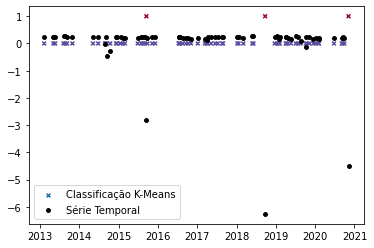

In [251]:
import matplotlib.dates as mdates
ts = pd.to_datetime(cols[2:])
fig2,ax2 = plt.subplots()    
km = plt.scatter(ts,assigned_clusters,c=assigned_clusters,cmap='Spectral_r',s=15,marker='x')
st = plt.scatter(ts,X_scaled,c='k',s=15)
plt.legend((km,st),('Classificação K-Means','Série Temporal'))
plt.show()

In [252]:
def count_kmeans(kmean):
    return np.count_nonzero(kmean)

count_kmeans(assigned_clusters)

3

In [253]:
def kmeans(df):
    scaler = StandardScaler()
    X = df.to_numpy().reshape(-1,1)
    X_scaled = scaler.fit_transform(X)
    km_clust = KMeans(n_clusters=2)
    assigned_clusters = km_clust.fit_predict(X_scaled)
    return count_kmeans(assigned_clusters)

In [264]:
def OCSVM(df):
    scaler = StandardScaler()
    y = df.to_numpy().reshape(-1, 1)
    y_s = scaler.fit_transform(y)
    res = OneClassSVM(nu=0.05).fit_predict(y_s)
    return count_anomaly(res)

def RC(df):
    scaler = StandardScaler()
    y = df.to_numpy().reshape(-1, 1)
    y_s = scaler.fit_transform(y)
    res = EllipticEnvelope(support_fraction=5,random_state=0).fit_predict(y_s)
    return count_anomaly(res)

def ISO(df):
    scaler = StandardScaler()
    y = df.to_numpy().reshape(-1, 1)
    y_s = scaler.fit_transform(y)
    res = IsolationForest(n_estimators=5,random_state=0).fit_predict(y_s)
    return count_anomaly(res)

def LOCAL(df):
    scaler = StandardScaler()
    y = df.to_numpy().reshape(-1, 1)
    y_s = scaler.fit_transform(y)
    res = LocalOutlierFactor(n_neighbors=5, metric='braycurtis').fit_predict(y_s)
    return count_anomaly(res)

In [265]:
dts = df15c.head()
inicio = time.time()
dts.loc[:,'One-Class SVM'] = dts.apply(OCSVM, axis=1)
inicio2 = time.time()
dts.loc[:,'Robust Covariance'] = dts.apply(RC, axis=1)
inicio3 = time.time()
dts.loc[:,'Isolation Forest'] = dts.apply(ISO, axis=1)
inicio4 = time.time()
dts.loc[:,'Local Outlier Factor'] = dts.apply(LOCAL, axis=1)
inicio5 = time.time()
dts.loc[:,'K-Means'] = dts.apply(kmeans, axis=1)
fim = time.time()
print((inicio2 - inicio)*50000/60, "minutos") 
print((inicio3 - inicio2)*50000/60, "minutos")
print((inicio4 - inicio3)*50000/60, "minutos")
print((inicio5 - inicio4)*50000/60, "minutos")
print((fim - inicio5)*50000/60, "minutos")
dts.head()

18.335580825805664 minutos
55.01508712768555 minutos
106.46720727284749 minutos
16.74950122833252 minutos
108.60403378804524 minutos


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950     0.026303    0.028317    0.029046    0.029652   
         -43.4949     0.023742    0.026750    0.028640    0.029594   
         -43.4947     0.023143    0.026160    0.027222    0.028691   
         -43.4946     0.026471    0.028954    0.029070    0.030495   
         -43.4945     0.024371    0.027365    0.028118    0.029635   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950     0.028838    0.029453    0.025805    0.030751   
         -43.4949     0.026321    0.027524    0.023921    0.030174   
         -43.4947     0.024713    0.026736    0.023473    0.030216   
         -43.4946     0.028467    0.029205    0.026193    0.030785   
         -43.4945     0.026316    0.028359    0.025401    0.030383   

                    28-05-2018  01-09-2018  ...  09-06-2020  25-06-2020  \
Latitude Longitude                          ...                           
-20.2453 -43.4950     0.029026    0.027661  ...    0.029748    0.028241   
         -43.4949     0.025436    0.025432  ...    0.026882    0.025867   
         -43.4947     0.019696    0.024644  ...    0.025294    0.025165   
         -43.4946     0.022136    0.027441  ...    0.029169    0.027786   
         -43.4945     0.020395    0.026111  ...    0.026793    0.026435   

                    11-07-2020  13-09-2020  29-09-2020  One-Class SVM  \
Latitude Longitude                                                      
-20.2453 -43.4950     0.039285    0.025696    0.026910             27   
         -43.4949     0.049379    0.023661    0.026121             15   
         -43.4947     0.046109    0.023348    0.025967             17   
         -43.4946     0.051588    0.025776    0.027343             20   
         -43.4945     0.055122    0.024821    0.027183             18   

                    Local Outlier Factor  Robust Covariance  Isolation Forest  \
Latitude Longitude                                                              
-20.2453 -43.4950                     16                  8                 8   
         -43.4949                     16                  8                 9   
         -43.4947                     22                  8                 9   
         -43.4946                     23                  8                10   
         -43.4945                     17                  8                10   

                    K-Means  
Latitude Longitude           
-20.2453 -43.4950         2  
         -43.4949         4  
         -43.4947         3  
         -43.4946         2  
         -43.4945         4  

[5 rows x 76 columns]

In [266]:
st = time.time()
dt23 = df_r15c
dt23['K-Means'] = dt23.loc[:,'02-08-2013':'29-09-2020'].apply(kmeans, axis=1)
fin = time.time()
print((fin - st)/60)
dt23.head()

106.427208062013


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000033   -0.000194   -0.000479   -0.000229   
         -43.4949    -0.000052   -0.000198   -0.000610   -0.000322   
         -43.4947    -0.000163   -0.000006   -0.000684   -0.000363   
         -43.4946    -0.000122   -0.000007   -0.000631   -0.000326   
         -43.4945    -0.000192   -0.000004   -0.000604   -0.000321   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000003   -0.000524   -0.000116    0.000105   
         -43.4949    -0.000058   -0.000484   -0.000079    0.000269   
         -43.4947    -0.000156   -0.000404   -0.000046    0.000361   
         -43.4946    -0.000064   -0.000422   -0.000084    0.000048   
         -43.4945    -0.000171   -0.000414   -0.000083    0.000124   

                    28-05-2018    01-09-2018  ...  09-06-2020  25-06-2020  \
Latitude Longitude                            ...                           
-20.2453 -43.4950     0.000027 -8.441663e-06  ...   -0.000495   -0.000296   
         -43.4949    -0.000087 -2.466818e-06  ...   -0.000664   -0.000358   
         -43.4947     0.000229  1.255498e-07  ...   -0.000970   -0.000502   
         -43.4946     0.000228 -5.340677e-07  ...   -0.000783   -0.000540   
         -43.4945     0.000277  5.417275e-07  ...   -0.001078   -0.000602   

                    11-07-2020  13-09-2020  29-09-2020  One-Class SVM  \
Latitude Longitude                                                      
-20.2453 -43.4950    -0.037669   -0.000018   -0.000845              2   
         -43.4949    -0.052209    0.000019   -0.000995              3   
         -43.4947    -0.058080    0.000003   -0.000741              3   
         -43.4946    -0.065237   -0.000002   -0.000600              1   
         -43.4945    -0.071281    0.000010   -0.000700              4   

                    Local Outlier Factor  Isolation Forest  Robust Covariance  \
Latitude Longitude                                                              
-20.2453 -43.4950                      8                 9                  7   
         -43.4949                     11                10                  8   
         -43.4947                      8                10                  8   
         -43.4946                     14                 9                  7   
         -43.4945                      8                 9                  7   

                    K-Means  
Latitude Longitude           
-20.2453 -43.4950         1  
         -43.4949         3  
         -43.4947         3  
         -43.4946         3  
         -43.4945         2  

[5 rows x 76 columns]

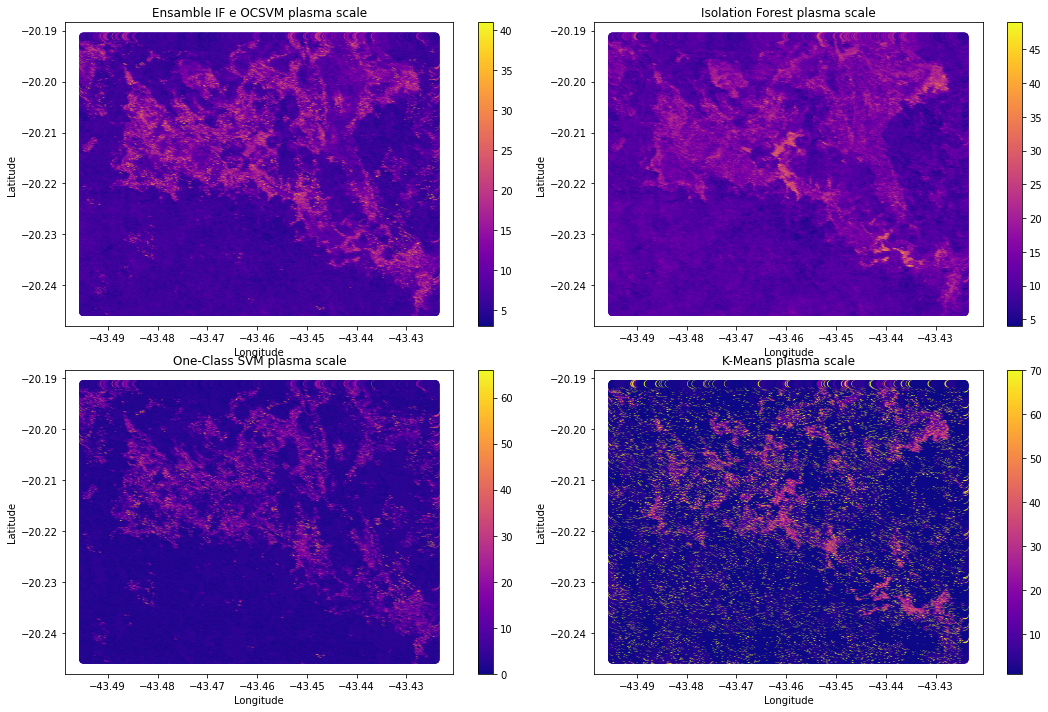

In [282]:
y = df_r15['Latitude'].values
x = df_r15['Longitude'].values
fig, ax = plt.subplots(2,2, figsize=(15,10))
mask1 = dt23['Local Outlier Factor'].values
mask2 = dt23['Isolation Forest'].values
mask3 = dt23['One-Class SVM'].values
mask4 = dt23['K-Means'].values
mask5 = (mask2 + mask3)/2
ax[0,0].scatter(x,y,c=mask5,cmap='plasma')
ax[0,0].set_title('Ensemble IF e OCSVM plasma scale')
plt.colorbar(ax[0,0].scatter(x,y,c=mask5,cmap='plasma'),ax=ax[0,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[0,1].scatter(x,y,c=mask2,cmap='plasma')
ax[0,1].set_title('Isolation Forest plasma scale')
plt.colorbar(ax[0,1].scatter(x,y,c=mask2,cmap='plasma'),ax=ax[0,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,0].scatter(x,y,c=mask3,cmap='plasma')
ax[1,0].set_title('One-Class SVM plasma scale')
plt.colorbar(ax[1,0].scatter(x,y,c=mask3,cmap='plasma'),ax=ax[1,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,1].scatter(x,y,c=mask4,cmap='plasma')
ax[1,1].set_title('K-Means plasma scale')
plt.colorbar(ax[1,1].scatter(x,y,c=mask4,cmap='plasma'),ax=ax[1,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
fig.tight_layout()
ax[0,0].set_xlabel("Longitude")
ax[0,0].set_ylabel("Latitude")
ax[0,1].set_xlabel("Longitude")
ax[0,1].set_ylabel("Latitude")
ax[1,0].set_xlabel("Longitude")
ax[1,0].set_ylabel("Latitude")
plt.show()

## DBSCAN

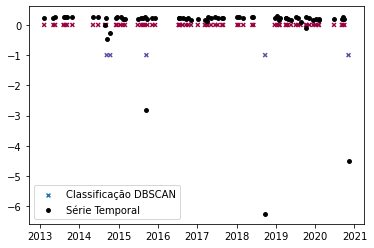

In [269]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(X_scaled)
fig3,ax3 = plt.subplots()    
km2 = plt.scatter(ts,clusters,c=clusters,cmap='Spectral_r',s=15,marker='x')
st2 = plt.scatter(ts,X_scaled,c='k',s=15)
plt.legend((km2,st2),('Classificação DBSCAN','Série Temporal'))
plt.show()

In [270]:
def DS(df):
    scaler = StandardScaler()
    y = df.to_numpy().reshape(-1, 1)
    y_s = scaler.fit_transform(y)
    outlier_detection = DBSCAN(eps = .2, metric='euclidean', min_samples = 5, n_jobs = -1)
    clusters = outlier_detection.fit_predict(y_s)
    return count_kmeans(clusters)

In [613]:
dtx = df15c.head()
inicio = time.time()
dtx.loc[:,'One-Class SVM'] = dts.loc[:,:'29-09-2020'].apply(OCSVM, axis=1)
inicio2 = time.time()
dtx.loc[:,'Robust Covariance'] = dts.loc[:,:'29-09-2020'].apply(RC, axis=1)
inicio3 = time.time()
dtx.loc[:,'Isolation Forest'] = dts.loc[:,:'29-09-2020'].apply(ISO, axis=1)
inicio4 = time.time()
dtx.loc[:,'Local Outlier Factor'] = dts.loc[:,:'29-09-2020'].apply(LOCAL, axis=1)
inicio5 = time.time()
dtx.loc[:,'K-Means'] = dts.loc[:,:'29-09-2020'].apply(kmeans, axis=1)
inicio6 = time.time()
dtx.loc[:,'DBSCAN'] = dts.loc[:,:'29-09-2020'].apply(DS, axis=1)
fim = time.time()
print((inicio2 - inicio)*50000/60, "minutos") 
print((inicio3 - inicio2)*50000/60, "minutos")
print((inicio4 - inicio3)*50000/60, "minutos")
print((inicio5 - inicio4)*50000/60, "minutos")
print((inicio6 - inicio5)*50000/60, "minutos")
print((fim - inicio6)*50000/60, "minutos")
dtx.head()

22.497375806172688 minutos
167.5248146057129 minutos
213.24634552001953 minutos
18.34253470102946 minutos
178.37584018707275 minutos
80.02082506815593 minutos


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950     0.026303    0.028317    0.029046    0.029652   
         -43.4949     0.023742    0.026750    0.028640    0.029594   
         -43.4947     0.023143    0.026160    0.027222    0.028691   
         -43.4946     0.026471    0.028954    0.029070    0.030495   
         -43.4945     0.024371    0.027365    0.028118    0.029635   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950     0.028838    0.029453    0.025805    0.030751   
         -43.4949     0.026321    0.027524    0.023921    0.030174   
         -43.4947     0.024713    0.026736    0.023473    0.030216   
         -43.4946     0.028467    0.029205    0.026193    0.030785   
         -43.4945     0.026316    0.028359    0.025401    0.030383   

                    28-05-2018  01-09-2018  ...  25-06-2020  11-07-2020  \
Latitude Longitude                          ...                           
-20.2453 -43.4950     0.029026    0.027661  ...    0.028241    0.039285   
         -43.4949     0.025436    0.025432  ...    0.025867    0.049379   
         -43.4947     0.019696    0.024644  ...    0.025165    0.046109   
         -43.4946     0.022136    0.027441  ...    0.027786    0.051588   
         -43.4945     0.020395    0.026111  ...    0.026435    0.055122   

                    13-09-2020  29-09-2020  One-Class SVM  \
Latitude Longitude                                          
-20.2453 -43.4950     0.025696    0.026910             17   
         -43.4949     0.023661    0.026121              7   
         -43.4947     0.023348    0.025967             10   
         -43.4946     0.025776    0.027343             22   
         -43.4945     0.024821    0.027183              7   

                    Local Outlier Factor  Robust Covariance  Isolation Forest  \
Latitude Longitude                                                              
-20.2453 -43.4950                     17                  7                15   
         -43.4949                     13                  8                15   
         -43.4947                     12                  8                16   
         -43.4946                     13                  8                17   
         -43.4945                      9                  7                17   

                    K-Means  DBSCAN  
Latitude Longitude                   
-20.2453 -43.4950         7       9  
         -43.4949         4       9  
         -43.4947         5       8  
         -43.4946        65      11  
         -43.4945         1       9  

[5 rows x 77 columns]

In [286]:
st = time.time()
dt234 = df_r15c
dt234['DBSCAN'] = dt234.loc[:,'02-08-2013':'29-09-2020'].apply(DS, axis=1)
fin = time.time()
print((fin - st)/60)
dt234.head()

59.842497471968336


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000033   -0.000194   -0.000479   -0.000229   
         -43.4949    -0.000052   -0.000198   -0.000610   -0.000322   
         -43.4947    -0.000163   -0.000006   -0.000684   -0.000363   
         -43.4946    -0.000122   -0.000007   -0.000631   -0.000326   
         -43.4945    -0.000192   -0.000004   -0.000604   -0.000321   

                    25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude Longitude                                                   
-20.2453 -43.4950    -0.000003   -0.000524   -0.000116    0.000105   
         -43.4949    -0.000058   -0.000484   -0.000079    0.000269   
         -43.4947    -0.000156   -0.000404   -0.000046    0.000361   
         -43.4946    -0.000064   -0.000422   -0.000084    0.000048   
         -43.4945    -0.000171   -0.000414   -0.000083    0.000124   

                    28-05-2018    01-09-2018  ...  25-06-2020  11-07-2020  \
Latitude Longitude                            ...                           
-20.2453 -43.4950     0.000027 -8.441663e-06  ...   -0.000296   -0.037669   
         -43.4949    -0.000087 -2.466818e-06  ...   -0.000358   -0.052209   
         -43.4947     0.000229  1.255498e-07  ...   -0.000502   -0.058080   
         -43.4946     0.000228 -5.340677e-07  ...   -0.000540   -0.065237   
         -43.4945     0.000277  5.417275e-07  ...   -0.000602   -0.071281   

                    13-09-2020  29-09-2020  One-Class SVM  \
Latitude Longitude                                          
-20.2453 -43.4950    -0.000018   -0.000845              2   
         -43.4949     0.000019   -0.000995              3   
         -43.4947     0.000003   -0.000741              3   
         -43.4946    -0.000002   -0.000600              1   
         -43.4945     0.000010   -0.000700              4   

                    Local Outlier Factor  Isolation Forest  Robust Covariance  \
Latitude Longitude                                                              
-20.2453 -43.4950                      8                 9                  7   
         -43.4949                     11                10                  8   
         -43.4947                      8                10                  8   
         -43.4946                     14                 9                  7   
         -43.4945                      8                 9                  7   

                    K-Means  DBSCAN  
Latitude Longitude                   
-20.2453 -43.4950         1       5  
         -43.4949         3       7  
         -43.4947         3       6  
         -43.4946         3       5  
         -43.4945         2       5  

[5 rows x 77 columns]

In [562]:
dt234.to_csv('Mariana_anomaly.csv')

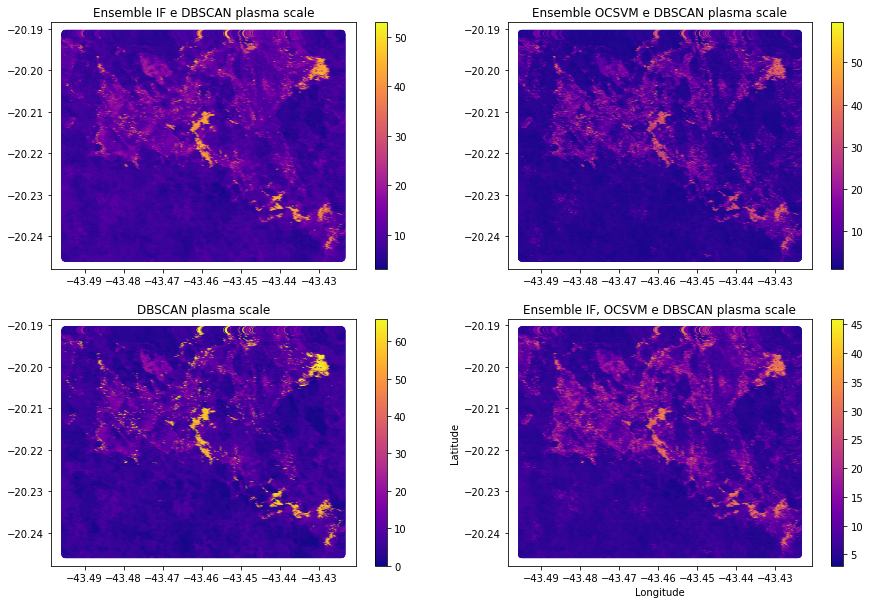

In [569]:
figw, axw = plt.subplots(2,2, figsize=(15,10))
mask8 = dt234['DBSCAN'].values
mask6 = (mask2 + mask8)/2
mask7 = (mask3 + mask8)/2
mask9 = (mask2 + mask3 + mask8)/3
axw[0,0].scatter(x,y,c=mask6,cmap='plasma')
axw[0,0].set_title('Ensemble IF e DBSCAN plasma scale')
plt.colorbar(axw[0,0].scatter(x,y,c=mask6,cmap='plasma'),ax=axw[0,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
axw[0,1].scatter(x,y,c=mask7,cmap='plasma')
axw[0,1].set_title('Ensemble OCSVM e DBSCAN plasma scale')
plt.colorbar(axw[0,1].scatter(x,y,c=mask7,cmap='plasma'),ax=axw[0,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
axw[1,0].scatter(x,y,c=mask8,cmap='plasma')
axw[1,0].set_title('DBSCAN plasma scale')
plt.colorbar(axw[1,0].scatter(x,y,c=mask8,cmap='plasma'),ax=axw[1,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
axw[1,1].scatter(x,y,c=mask9,cmap='plasma')
axw[1,1].set_title('Ensemble IF, OCSVM e DBSCAN plasma scale')
plt.colorbar(axw[1,1].scatter(x,y,c=mask9,cmap='plasma'),ax=axw[1,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [295]:
dt234.iloc[:,-6:].apply(np.std, axis=0)

One-Class SVM            6.589707
Local Outlier Factor     3.954797
Isolation Forest         3.966584
Robust Covariance        0.430663
K-Means                 17.845612
DBSCAN                   9.461825
dtype: float64

In [296]:
dt234.iloc[:,-6:].apply(np.mean, axis=0)

One-Class SVM            5.828106
Local Outlier Factor     9.939919
Isolation Forest        12.227841
Robust Covariance        7.245973
K-Means                  8.517655
DBSCAN                   7.996690
dtype: float64

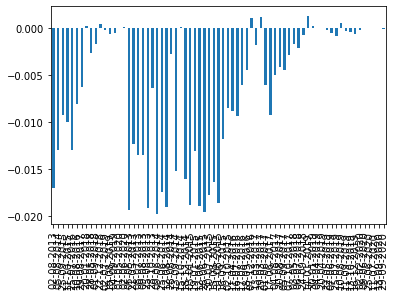

In [439]:
figz, axz = plt.subplots()
dt234.loc[dt234['Isolation Forest'].idxmax(),:'29-09-2020'].plot.bar(x=serie,stacked=True)
plt.show()

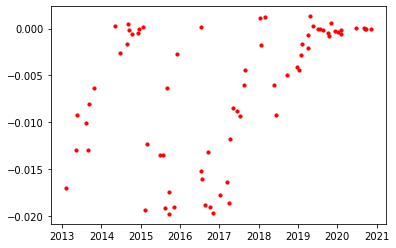

In [397]:
valo = dt234.loc[dt234['Isolation Forest'].idxmax(),:'29-09-2020'].values.reshape(-1,1)
f,a = plt.subplots()
plt.scatter(ts.sort_values(),valo,s=10,color='red')
plt.show()

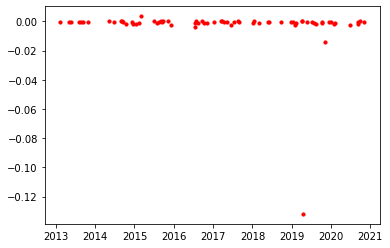

In [566]:
valomin = dt234.loc[dt234['Isolation Forest'].idxmin(),:'29-09-2020'].values.reshape(-1,1)
f2,a2 = plt.subplots()
plt.scatter(ts.sort_values(),valomin,s=10,color='red')
plt.show()

## Média móvel

In [409]:
serie = ts.sort_values()
dia = abs(((serie[70]-serie[0])/len(serie)).days)
print("a média do intervalo entre os instantes é de", dia, "dias")

a média do intervalo entre os instantes é de 39 dias


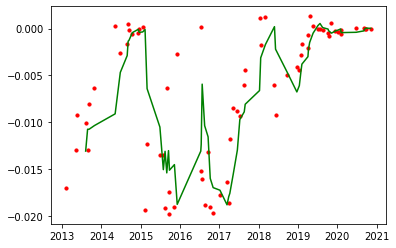

In [436]:
medy = []
for i in range(len(serie)-3):
    medy.append((np.sum(valo[i:i+3]))/3)

f,a = plt.subplots()
plt.scatter(ts.sort_values(),valo,s=10,color='red')
plt.plot(serie[3:],medy,color='green')
plt.show()

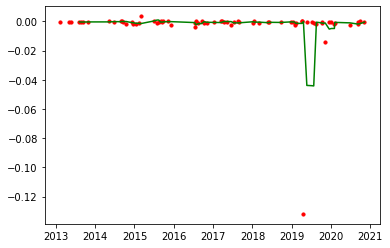

In [567]:
medymin = []
for i in range(len(serie)-3):
    medymin.append((np.sum(valomin[i:i+3]))/3)

f2,a2 = plt.subplots()
plt.scatter(ts.sort_values(),valomin,s=10,color='red')
plt.plot(serie[3:],medymin,color='green')
plt.show()

In [570]:
def med_movel(serie):
    medias = []
    for i in range(len(serie)-5):
        medias.append((np.sum(serie[i:i+5]))/5)
    
    return medias

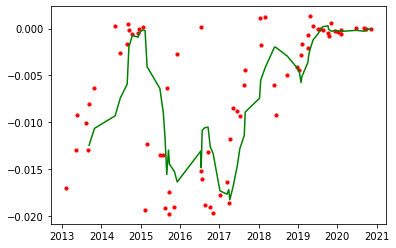

In [437]:
medy5 = []
for i in range(len(serie)-5):
    medy5.append((np.sum(valo[i:i+5]))/5)

f,a = plt.subplots()
plt.scatter(ts.sort_values(),valo,s=10,color='red')
plt.plot(serie[5:],medy5,color='green')
plt.show()

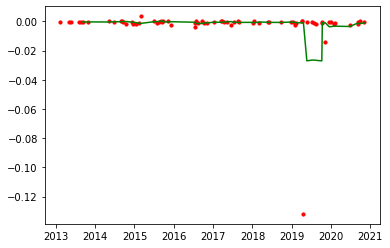

In [568]:
medy5m = []
for i in range(len(serie)-5):
    medy5m.append((np.sum(valomin[i:i+5]))/5)

f,a = plt.subplots()
plt.scatter(ts.sort_values(),valomin,s=10,color='red')
plt.plot(serie[5:],medy5m,color='green')
plt.show()

In [440]:
def media_movel_5(serie):
    vec = []
    for i in range(len(serie)-5):
        vec.append((np.sum(serie[i:i+5]))/5)
        
    return vec

def media_movel_3(serie):
    vec = []
    for i in range(len(serie)-3):
        vec.append((np.sum(serie[i:i+3]))/3)
        
    return vec

In [449]:
dataframe_mediana = pd.DataFrame(columns=['NDVI', 'NDWI'])
la,lo,inds = ext_lat_lon_pixel15(imagem,geometria,['ndvip','ndwip'])
dataframe_mediana['NDVI'] = inds[0]
dataframe_mediana['NDWI'] = inds[1]
dataframe_mediana = dataframe_mediana.assign(Latitude = lat15)
dataframe_mediana = dataframe_mediana.assign(Longitude = lon15)
dataframe_mediana = dataframe_mediana.set_index(['Latitude','Longitude'])
dataframe_mediana.head()

NDVI      NDWI
Latitude   Longitude                     
-20.245309 -43.495011 -0.000353 -0.000175
           -43.494876 -0.000378 -0.000205
           -43.494742 -0.000220 -0.000182
           -43.494607 -0.000154 -0.000168
           -43.494472 -0.000194 -0.000160

In [614]:
dataframe_mediana.index[0]

(-20.245309100319556, -43.495011210494745)

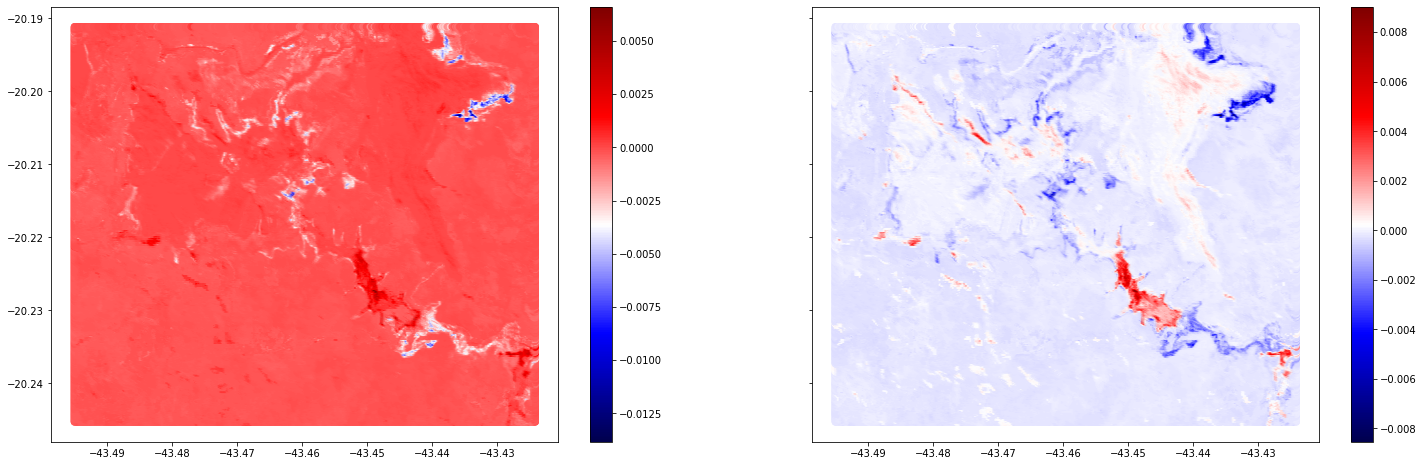

In [572]:
ndvi = dataframe_mediana['NDVI'].values
ndwi = dataframe_mediana['NDWI'].values
fi,(ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True,figsize=(25,8))
ax1.scatter(lo,la,c=ndvi,cmap='seismic')
plt.colorbar(ax1.scatter(lo,la,c=ndvi,cmap='seismic'),ax=ax1)
ax2.scatter(lo,la,c=ndwi,cmap='seismic')
plt.colorbar(ax2.scatter(lo,la,c=ndwi,cmap='seismic'),ax=ax2)
plt.show()

## Mudança de Parâmetro: NDWI

In [461]:
listaCNw = cole.toList(cole.size())
defaultDummy = -99999
dfw = pd.DataFrame()
diw = {}
dias = df['Data'].values
for j in range(cole.size().getInfo()):
    tempndwi = str(dias[j])
    img = ee.Image(defaultDummy).blend(ee.Image(listaCNw.get(j)))
    lat15, lon15, indw15 = ext_lat_lon_pixel15(img,geometria,['ndwip'])
    diw[tempndwi] = indw15[0]
    
dfw = dfw.from_dict(diw)
dfw = dfw.assign(Latitude = lat15)
dfw = dfw.assign(Longitude = lon15)
colsw = dfw.columns.tolist()
colsw = colsw[-2:] + colsw[:-2]
dfw = dfw[colsw]
dfw = dfw.set_index(['Latitude','Longitude'])

NameError: name 'dfw15' is not defined

In [462]:
dfw.head()

02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude   Longitude                                                      
-20.245309 -43.495011 -1.289437e-07   -0.000201   -0.000379   -0.000130   
           -43.494876 -2.031013e-07   -0.000206   -0.000483   -0.000182   
           -43.494742 -4.299025e-05   -0.000014   -0.000522   -0.000206   
           -43.494607 -3.237069e-05   -0.000017   -0.000481   -0.000185   
           -43.494472 -5.077355e-05   -0.000010   -0.000461   -0.000183   

                       25-07-2016  10-08-2016  29-08-2017  20-01-2018  \
Latitude   Longitude                                                    
-20.245309 -43.495011   -0.000003   -0.000395   -0.000037    0.000066   
           -43.494876   -0.000059   -0.000365   -0.000025    0.000168   
           -43.494742   -0.000147   -0.000299   -0.000031    0.000250   
           -43.494607   -0.000060   -0.000311   -0.000056    0.000033   
           -43.494472   -0.000161   -0.000306   -0.000056    0.000086   

                       28-05-2018    01-09-2018  ...  10-08-2019  11-09-2019  \
Latitude   Longitude                             ...                           
-20.245309 -43.495011    0.000005 -6.975577e-08  ...   -0.005046   -0.000180   
           -43.494876   -0.000015 -2.038399e-08  ...   -0.005431   -0.000209   
           -43.494742    0.000831 -3.987221e-07  ...   -0.003393   -0.000090   
           -43.494607    0.000829  1.696097e-06  ...   -0.002418   -0.000086   
           -43.494472    0.001005 -1.720423e-06  ...   -0.002488   -0.000080   

                       13-10-2019  16-12-2019  02-02-2020  09-06-2020  \
Latitude   Longitude                                                    
-20.245309 -43.495011    0.000004   -0.000587   -0.000303   -0.000385   
           -43.494876   -0.000071   -0.000407   -0.000278   -0.000516   
           -43.494742    0.000020   -0.000515   -0.000430   -0.000636   
           -43.494607    0.000026   -0.000828   -0.000622   -0.000513   
           -43.494472    0.000031   -0.000613   -0.000602   -0.000707   

                       25-06-2020  11-07-2020    13-09-2020  29-09-2020  
Latitude   Longitude                                                     
-20.245309 -43.495011   -0.000232   -0.024100 -1.553499e-05   -0.000802  
           -43.494876   -0.000282   -0.033403  1.728176e-05   -0.000944  
           -43.494742   -0.000400   -0.036541  1.316248e-06   -0.000649  
           -43.494607   -0.000431   -0.041044 -8.859154e-07   -0.000526  
           -43.494472   -0.000481   -0.044847  4.518877e-06   -0.000613  

[5 rows x 71 columns]

In [564]:
dtxw = dfw
inicio = time.time()
dtxw.loc[:,'One-Class SVM'] = dtxw.loc[:,:'29-09-2020'].apply(OCSVM, axis=1)
inicio2 = time.time()
dtxw.loc[:,'Isolation Forest'] = dtxw.loc[:,:'29-09-2020'].apply(ISO, axis=1)
inicio4 = time.time()
dtxw.loc[:,'K-Means'] = dtxw.loc[:,:'29-09-2020'].apply(kmeans, axis=1)
inicio6 = time.time()
dtxw.loc[:,'DBSCAN'] = dtxw.loc[:,:'29-09-2020'].apply(DS, axis=1)
fim = time.time()
print((inicio2 - inicio)*50000/60, "minutos") 
print((inicio4 - inicio2)*50000/60, "minutos")
print((inicio6 - inicio4)*50000/60, "minutos")
print((fim - inicio6)*50000/60, "minutos")
dtxw

463045.88337739307 minutos
5169336.987932523 minutos
5335379.441976547 minutos
3005466.7460918427 minutos


02-08-2013  05-08-2014  25-09-2015  11-10-2015  \
Latitude   Longitude                                                      
-20.245309 -43.495011 -1.289437e-07   -0.000201   -0.000379   -0.000130   
           -43.494876 -2.031013e-07   -0.000206   -0.000483   -0.000182   
           -43.494742 -4.299025e-05   -0.000014   -0.000522   -0.000206   
           -43.494607 -3.237069e-05   -0.000017   -0.000481   -0.000185   
           -43.494472 -5.077355e-05   -0.000010   -0.000461   -0.000183   
...                             ...         ...         ...         ...   
-20.191141 -43.424673  6.710057e-07   -0.000222   -0.000638   -0.000564   
           -43.424538  7.277192e-07   -0.000162   -0.000673   -0.000493   
           -43.424404  6.407194e-07   -0.000227   -0.000755   -0.000522   
           -43.424269  1.943777e-06   -0.000208   -0.000879   -0.000627   
           -43.424134  2.988630e-06   -0.000190   -0.000785   -0.000579   

                       25-07-2016  10-08-2016    29-08-2017  20-01-2018  \
Latitude   Longitude                                                      
-20.245309 -43.495011   -0.000003   -0.000395 -3.720498e-05    0.000066   
           -43.494876   -0.000059   -0.000365 -2.539774e-05    0.000168   
           -43.494742   -0.000147   -0.000299 -3.058009e-05    0.000250   
           -43.494607   -0.000060   -0.000311 -5.621525e-05    0.000033   
           -43.494472   -0.000161   -0.000306 -5.557722e-05    0.000086   
...                           ...         ...           ...         ...   
-20.191141 -43.424673   -0.000007   -0.000425 -6.082282e-06    0.000343   
           -43.424538   -0.000056   -0.000343  6.835924e-07    0.000082   
           -43.424404   -0.000065   -0.000443 -1.250578e-05    0.000215   
           -43.424269   -0.000020   -0.000413 -8.911425e-06    0.000091   
           -43.424134   -0.000031   -0.000352  9.838135e-06    0.000064   

                         28-05-2018    01-09-2018  ...  02-02-2020  \
Latitude   Longitude                               ...               
-20.245309 -43.495011  4.609774e-06 -6.975577e-08  ...   -0.000303   
           -43.494876 -1.500213e-05 -2.038399e-08  ...   -0.000278   
           -43.494742  8.308359e-04 -3.987221e-07  ...   -0.000430   
           -43.494607  8.285767e-04  1.696097e-06  ...   -0.000622   
           -43.494472  1.005470e-03 -1.720423e-06  ...   -0.000602   
...                             ...           ...  ...         ...   
-20.191141 -43.424673  2.257771e-06  1.667557e-05  ...   -0.000012   
           -43.424538  2.249017e-05 -5.271364e-06  ...   -0.000237   
           -43.424404  8.970923e-06 -5.337499e-06  ...   -0.000198   
           -43.424269  9.388318e-08 -1.278603e-05  ...   -0.000147   
           -43.424134 -7.596707e-08 -1.757340e-06  ...   -0.000120   

                       09-06-2020  25-06-2020    11-07-2020    13-09-2020  \
Latitude   Longitude                                                        
-20.245309 -43.495011   -0.000385   -0.000232 -2.410041e-02 -1.553499e-05   
           -43.494876   -0.000516   -0.000282 -3.340302e-02  1.728176e-05   
           -43.494742   -0.000636   -0.000400 -3.654144e-02  1.316248e-06   
           -43.494607   -0.000513   -0.000431 -4.104447e-02 -8.859154e-07   
           -43.494472   -0.000707   -0.000481 -4.484705e-02  4.518877e-06   
...                           ...         ...           ...           ...   
-20.191141 -43.424673   -0.000084   -0.000044  1.268595e-05  8.295562e-06   
           -43.424538   -0.000132   -0.000103  1.058589e-07 -1.752625e-07   
           -43.424404   -0.000148   -0.000106 -2.755307e-06 -1.630695e-06   
           -43.424269   -0.000141   -0.000098  1.465091e-06 -9.347152e-07   
           -43.424134   -0.000133   -0.000055  3.308768e-07  1.004603e-06   

                       29-09-2020  One-Class SVM  Isolation Forest  K-Means  \
Latitude   Longitude                                                          
-2

In [575]:
dtxw.to_csv('Mariana_NDWI.csv')

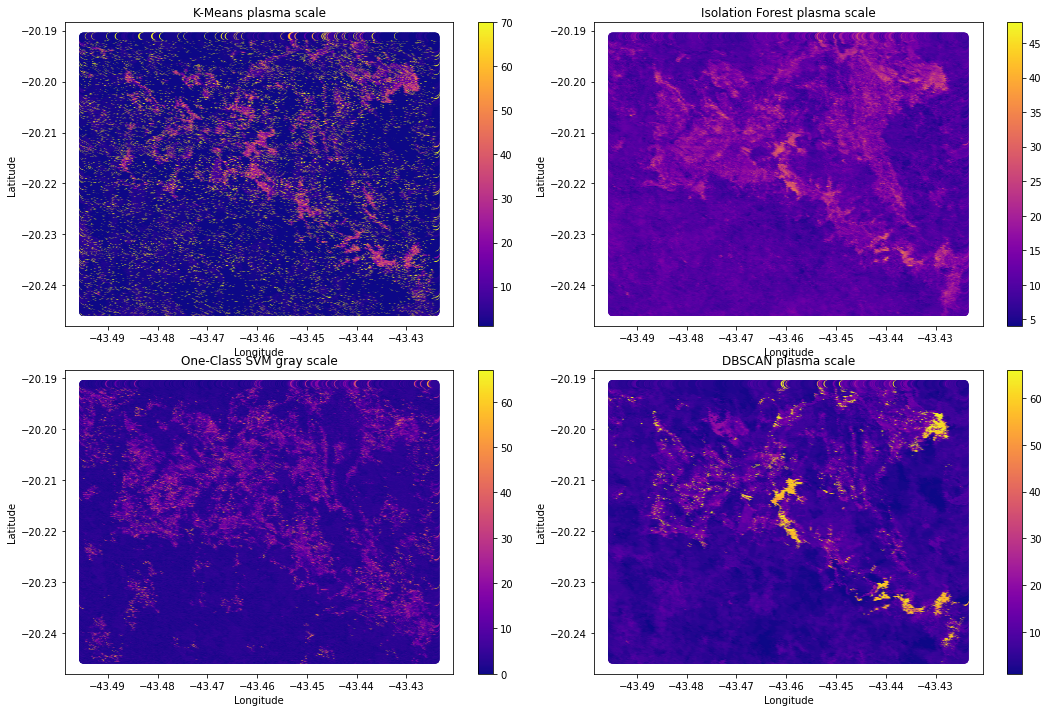

In [565]:
y = df_r15['Latitude'].values
x = df_r15['Longitude'].values
fig, ax = plt.subplots(2,2, figsize=(15,10))
wmask1 = dtxw['K-Means'].values
wmask2 = dtxw['Isolation Forest'].values
wmask3 = dtxw['One-Class SVM'].values
wmask4 = dtxw['DBSCAN'].values
ax[0,0].scatter(x,y,c=wmask1,cmap='plasma')
ax[0,0].set_title('K-Means plasma scale')
plt.colorbar(ax[0,0].scatter(x,y,c=wmask1,cmap='plasma'),ax=ax[0,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[0,1].scatter(x,y,c=wmask2,cmap='plasma')
ax[0,1].set_title('Isolation Forest plasma scale')
plt.colorbar(ax[0,1].scatter(x,y,c=wmask2,cmap='plasma'),ax=ax[0,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,0].scatter(x,y,c=wmask3,cmap='plasma')
ax[1,0].set_title('One-Class SVM gray scale')
plt.colorbar(ax[1,0].scatter(x,y,c=wmask3,cmap='plasma'),ax=ax[1,0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1,1].scatter(x,y,c=wmask4,cmap='plasma')
ax[1,1].set_title('DBSCAN plasma scale')
plt.colorbar(ax[1,1].scatter(x,y,c=wmask4,cmap='plasma'),ax=ax[1,1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
fig.tight_layout()
ax[0,0].set_xlabel("Longitude")
ax[0,0].set_ylabel("Latitude")
ax[0,1].set_xlabel("Longitude")
ax[0,1].set_ylabel("Latitude")
ax[1,0].set_xlabel("Longitude")
ax[1,0].set_ylabel("Latitude")
plt.show()

## Tentativa de padronização da série temporal

In [574]:
tempos = serie
novot = []
for i in range(len(tempos)-1):
    if abs(tempos[i+1]-tempos[i]).days >= 30:
        novot.append(tempos[i])
        
len(novot)

32

In [510]:
datastr = []
for i in range(len(novot)):
    t = datetime.strptime(str(novot[i]), '%Y-%m-%d %H:%M:%S')
    datastr.append(t)

In [561]:
templist = []
for i in range(len(novot)):
    string = ''
    if datastr[i].day < 10:
        x = '0'+str(datastr[i].day)
    else:
        x = str(datastr[i].day)
    if datastr[i].month < 10:
        y = '0'+str(datastr[i].month)
    else:
        y = str(datastr[i].month)
    string = x + '-' + y + '-' + str(datastr[i].year)
    templist.append(string)